## Poisson Distribution
The Poisson distribution is a discrete probability distribution that models the number of events occurring in a fixed interval of time or space, given a known average rate (lambda) of occurrence.

Here we test to detect hourly spikes using:

1. Poisson PMF
2. Poisson CDF
3. Z-Score Method
4. Poisson GLM Model
5. Negative BinomiaL Model
4. Conclusion



#### Loading datasets

In [3]:
import pandas as pd
df_hrly=pd.read_csv('flash_sale_hourly_data.csv',parse_dates=['date'])
df_hrly.info()
df_hrly.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 120 non-null    datetime64[ns]
 1   hour                 120 non-null    int64         
 2   is_flash_sale_hour   120 non-null    bool          
 3   visitors             120 non-null    int64         
 4   customers            120 non-null    int64         
 5   conversion_rate      120 non-null    float64       
 6   orders               120 non-null    int64         
 7   orders_per_customer  120 non-null    float64       
dtypes: bool(1), datetime64[ns](1), float64(2), int64(4)
memory usage: 6.8 KB


,date,hour,is_flash_sale_hour,visitors,customers,conversion_rate,orders,orders_per_customer
0,2023-01-02,0,False,12,0,0.000000,0,0.0
1,2023-01-02,1,False,12,0,0.000000,0,0.0
2,2023-01-02,2,False,12,1,0.083333,5,5.0
3,2023-01-02,3,False,12,1,0.083333,2,2.0
4,2023-01-02,4,False,12,2,0.166667,1,0.5


#### Identifying Lambda

###### Lambda
- is the average rate of events occuring in a fixed time/space.
- 'orders' column is chosen to calculate lambda because it directly represent the count of events(orders) occuring in fixed hourly intervals.
- 'orders' columns meet Poisson Distribution Requirements: Discrete counts, Fixed intervals and independent events.

#### Checking Overdispersion

The Poisson distribution assumes--If we are modeling count data(like  hourly orders), the underlying assumption is:
- mean = variance

when Variance > mean = Overdispersion

###### Causes of overdispersion
- Unobserved factors or missing variable (like promotion, holidays,marketing)
- Heterogeneous data
- Poisson may not fit well because it underestimates the variance in the data

###### Solutions
- Switch to a Negative Binomial distribution
- Use a mixture model(flash and non-flash)
- Use Zero-inflated Poisson(ZIP): if your data has many zeros.



In [6]:
mean_orders=df_hrly['orders'].mean()
var_orders=df_hrly['orders'].var()

print(f"Mean: {mean_orders}, Variance: {var_orders}")
print("Overdispersed?" , var_orders > mean_orders)

Mean: 9.55, Variance: 207.96386554621836
Overdispersed? True


#### Mixture models

In [10]:
#split data
flash_data = df_hrly[df_hrly['is_flash_sale_hour'] == True]
non_flash_data = df_hrly[df_hrly['is_flash_sale_hour'] == False]

#finding lambdha for flash and non flash
import numpy as np

lambda_flash =flash_data['orders'].mean()

lambda_non_flash = non_flash_data['orders'].mean() #baseline lambda

std_flash= flash_data['orders'].std()

print(f'lambda flash: {lambda_flash:.2f}')
print(f'lambda non flash: {lambda_non_flash:.2f}') 
print(f'Flash Std : {std_flash:.2f}')

lambda flash: 18.80
lambda non flash: 4.92
Flash Std : 20.78


### 1. Poisson PMF:

 The Poisson Probability Mass Function(PMF) models the probability of a given number of events occuring in fixed interval when
- Events occur independly.
- lambda is constant.
- Events are rare(low probability per trial)

In [13]:
from scipy.stats import poisson
#calculate poisson PMF
df_hrly['poisson_pmf'] =df_hrly['orders'].apply(lambda x: poisson.pmf(x, lambda_non_flash))

#define Spike Threshold
spike_threshold = 0.05

df_hrly['pmf_is_order_spike'] = df_hrly['poisson_pmf'] < spike_threshold

#creating event type function
def get_point_type(row):
    if row['is_flash_sale_hour'] and row['pmf_is_order_spike']:
        return 'Spike during Flash Sale'
    elif row['is_flash_sale_hour']:
        return 'Flash Sale Only'
    elif row['pmf_is_order_spike']:
        return 'Unexpected Spike'
    else:
        return 'Normal'

#calling and returing event type
df_hrly['pmf_event_type'] = df_hrly.apply(get_point_type, axis=1)
print(df_hrly['pmf_event_type'].value_counts())

df_hrly[['date','is_flash_sale_hour','hour','visitors','orders','poisson_pmf','pmf_is_order_spike','pmf_event_type']].head(30)

pmf_event_type
Unexpected Spike           46
Normal                     34
Spike during Flash Sale    32
Flash Sale Only             8
Name: count, dtype: int64


,date,is_flash_sale_hour,hour,visitors,orders,poisson_pmf,pmf_is_order_spike,pmf_event_type
0,2023-01-02,False,0,12,0,7.262726e-03,True,Unexpected Spike
1,2023-01-02,False,1,12,0,7.262726e-03,True,Unexpected Spike
2,2023-01-02,False,2,12,5,1.753677e-01,False,Normal
3,2023-01-02,False,3,12,2,8.808098e-02,False,Normal
4,2023-01-02,False,4,12,1,3.576893e-02,True,Unexpected Spike
5,2023-01-02,False,5,12,0,7.262726e-03,True,Unexpected Spike
6,2023-01-02,False,6,12,4,1.780383e-01,False,Normal
7,2023-01-02,False,7,12,3,1.445996e-01,False,Normal
8,2023-01-02,False,8,12,4,1.780383e-01,False,Normal
9,2023-01-02,False,9,37,1,3.576893e-02,True,Unexpected Spike


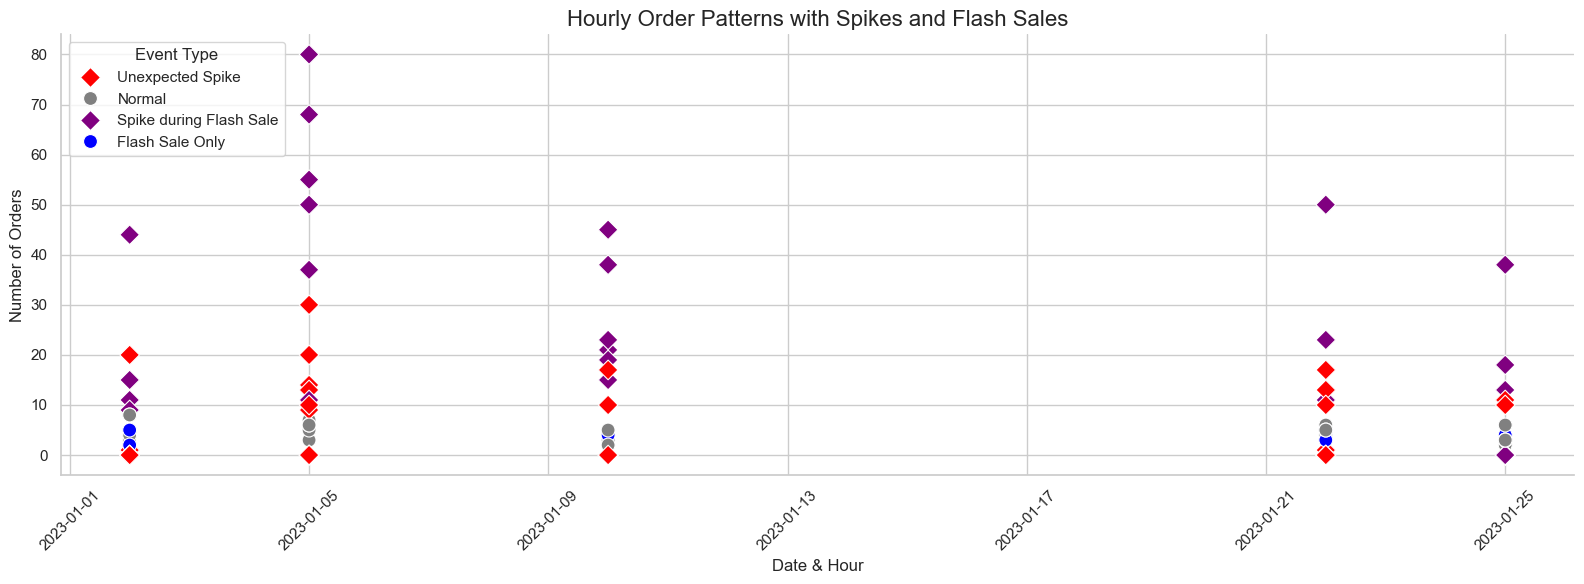

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set modern theme
sns.set_theme(style="whitegrid")

# Set up plot
plt.figure(figsize=(16, 6))

# Define colors and marker styles
palette = {
    'Normal': 'gray',
    'Flash Sale Only': 'blue',
    'Unexpected Spike': 'red',
    'Spike during Flash Sale': 'purple'
}

markers = {
    'Normal': 'o',
    'Flash Sale Only': 'o',
    'Unexpected Spike': 'D',
    'Spike during Flash Sale': 'D'
}

# Scatter plot with hue and style from event_type
sns.scatterplot(
    data=df_hrly,
    x='date', y='orders',
    hue='pmf_event_type',
    style='pmf_event_type',
    palette=palette,
    markers=markers,
    s=100
)

# Finishing touches
plt.title("Hourly Order Patterns with Spikes and Flash Sales", fontsize=16)
plt.xlabel("Date & Hour")
plt.ylabel("Number of Orders")
plt.legend(title="Event Type", loc="upper left", frameon=True)
plt.xticks(rotation=45)
plt.tight_layout()
sns.despine()
plt.savefig('pmf_order_spike.png')
plt.show()


#### Interpretation

- Extreme spikes in some hours (e.g., above 50–80 orders), especially during flash sales or unexpected events.

- Most other time slots hover around 5–15 orders.

- Data points are highly scattered and irregular — many fall far from the center of the distribution.

This suggests a long-tailed, spiky distribution, which is a classic symptom of overdispersion.



### 2. Poisson CDF

   The Poisson Culmulative Distribution Function(CDF) gives the probability that a Poisson distribution gives the probability that a Poisson-distributed random variable X is less than or equal to a value k:
   

In [17]:
#p_right_tail=P(X≥k)=1−P(X≤k−1)=1−poisson.cdf(k−1,lambda)
#1−P(X≤k−1)=P(X≥k)=P(X=k)+P(X=k+1)+⋯+P(X=n)
df_hrly['p_right_tail'] = df_hrly['orders'].apply(lambda x: 1 - poisson.cdf(x-1, lambda_non_flash))
#Flags days as flash sales if the observed orders are statistically significantly higher than expected (at 5% significance).
#define Spike Threshold
spike_threshold = 0.05

df_hrly['cdf_is_order_spike'] = df_hrly['p_right_tail'] < spike_threshold

#creating event type function
def get_point_type(row):
    if row['is_flash_sale_hour'] and row['cdf_is_order_spike']:
        return 'Spike during Flash Sale'
    elif row['is_flash_sale_hour']:
        return 'Flash Sale Only'
    elif row['cdf_is_order_spike']:
        return 'Unexpected Spike'
    else:
        return 'Normal'

#calling and returing event type
df_hrly['cdf_event_type'] = df_hrly.apply(get_point_type, axis=1)
print(df_hrly['cdf_event_type'].value_counts())

df_hrly[['date','is_flash_sale_hour','hour','visitors','orders','p_right_tail','cdf_is_order_spike','cdf_event_type']].head(30)

cdf_event_type
Normal                     64
Spike during Flash Sale    23
Flash Sale Only            17
Unexpected Spike           16
Name: count, dtype: int64


,date,is_flash_sale_hour,hour,visitors,orders,p_right_tail,cdf_is_order_spike,cdf_event_type
0,2023-01-02,False,0,12,0,1.000000e+00,False,Normal
1,2023-01-02,False,1,12,0,1.000000e+00,False,Normal
2,2023-01-02,False,2,12,5,5.462495e-01,False,Normal
3,2023-01-02,False,3,12,2,9.569683e-01,False,Normal
4,2023-01-02,False,4,12,1,9.927373e-01,False,Normal
5,2023-01-02,False,5,12,0,1.000000e+00,False,Normal
6,2023-01-02,False,6,12,4,7.242878e-01,False,Normal
7,2023-01-02,False,7,12,3,8.688874e-01,False,Normal
8,2023-01-02,False,8,12,4,7.242878e-01,False,Normal
9,2023-01-02,False,9,37,1,9.927373e-01,False,Normal


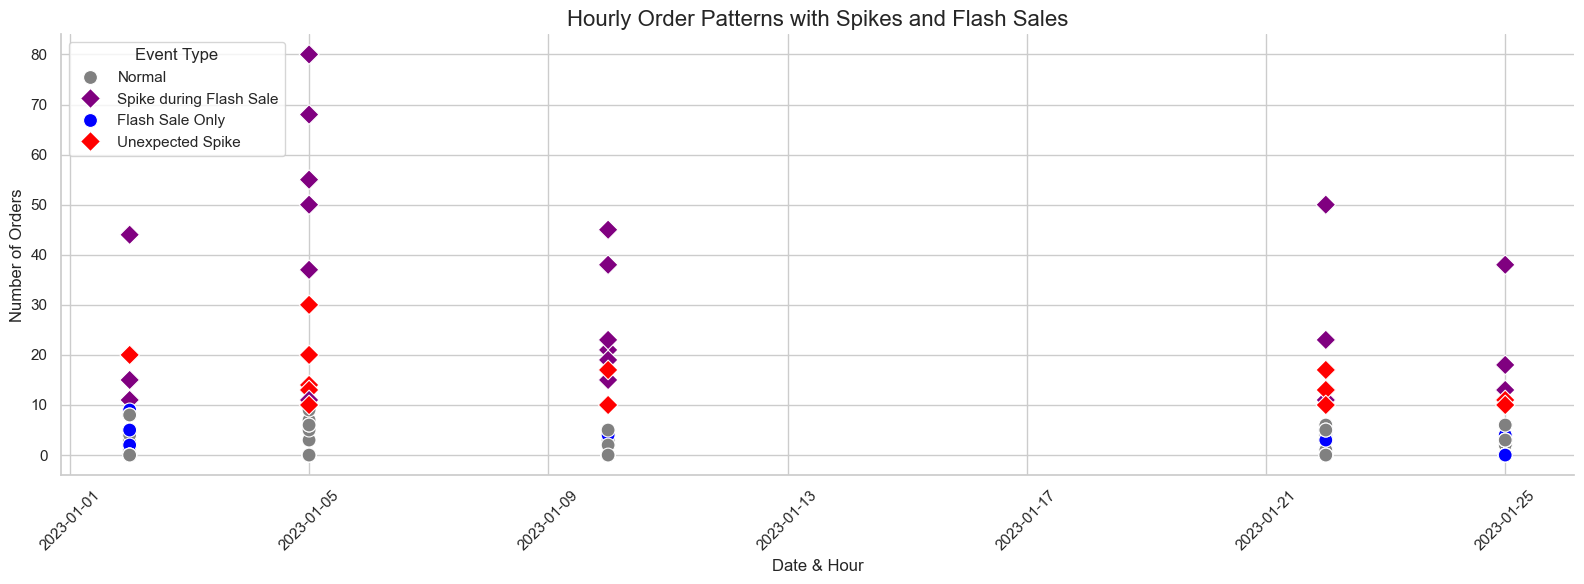

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set modern theme
sns.set_theme(style="whitegrid")

# Set up plot
plt.figure(figsize=(16, 6))

# Define colors and marker styles
palette = {
    'Normal': 'gray',
    'Flash Sale Only': 'blue',
    'Unexpected Spike': 'red',
    'Spike during Flash Sale': 'purple'
}

markers = {
    'Normal': 'o',
    'Flash Sale Only': 'o',
    'Unexpected Spike': 'D',
    'Spike during Flash Sale': 'D'
}

# Scatter plot with hue and style from event_type
sns.scatterplot(
    data=df_hrly,
    x='date', y='orders',
    hue='cdf_event_type',
    style='cdf_event_type',
    palette=palette,
    markers=markers,
    s=100
)

# Finishing touches
plt.title("Hourly Order Patterns with Spikes and Flash Sales", fontsize=16)
plt.xlabel("Date & Hour")
plt.ylabel("Number of Orders")
plt.legend(title="Event Type", loc="upper left", frameon=True)
plt.xticks(rotation=45)
plt.tight_layout()
sns.despine()
plt.savefig('pmf_order_spike.png')
plt.show()


#### Interpretation

- Extreme spikes in certain hours (e.g., 50–80 orders), often during flash sales or unexpected demand surges.

- Most other hours fall within a modest range of 5–15 orders.

- The distribution is highly scattered and long-tailed — many observations lie far from the center.

### 3. Z-score Method


In [22]:
import numpy as np
#calculating non flash mean and std
lambda_non_flash = non_flash_data['orders'].mean() #baseline lambda

std_non_flash= non_flash_data['orders'].std()
#calculate z_score 
df_hrly['z_score'] = (df_hrly['orders'] - lambda_non_flash) / std_non_flash
#filtering z_score order spike
df_hrly['is_spike_z'] = df_hrly['z_score'] > 2  # Z > 2 indicates spike


#creating event type function
def get_point_type(row):
    if row['is_flash_sale_hour'] and row['is_spike_z']:
        return 'Spike during Flash Sale'
    elif row['is_flash_sale_hour']:
        return 'Flash Sale Only'
    elif row['is_spike_z']:
        return 'Unexpected Spike'
    else:
        return 'Normal'

#calling and returing event type
df_hrly['z_event_type'] = df_hrly.apply(get_point_type, axis=1)
print(df_hrly['z_event_type'].value_counts())



z_event_type
Normal                     74
Flash Sale Only            25
Spike during Flash Sale    15
Unexpected Spike            6
Name: count, dtype: int64


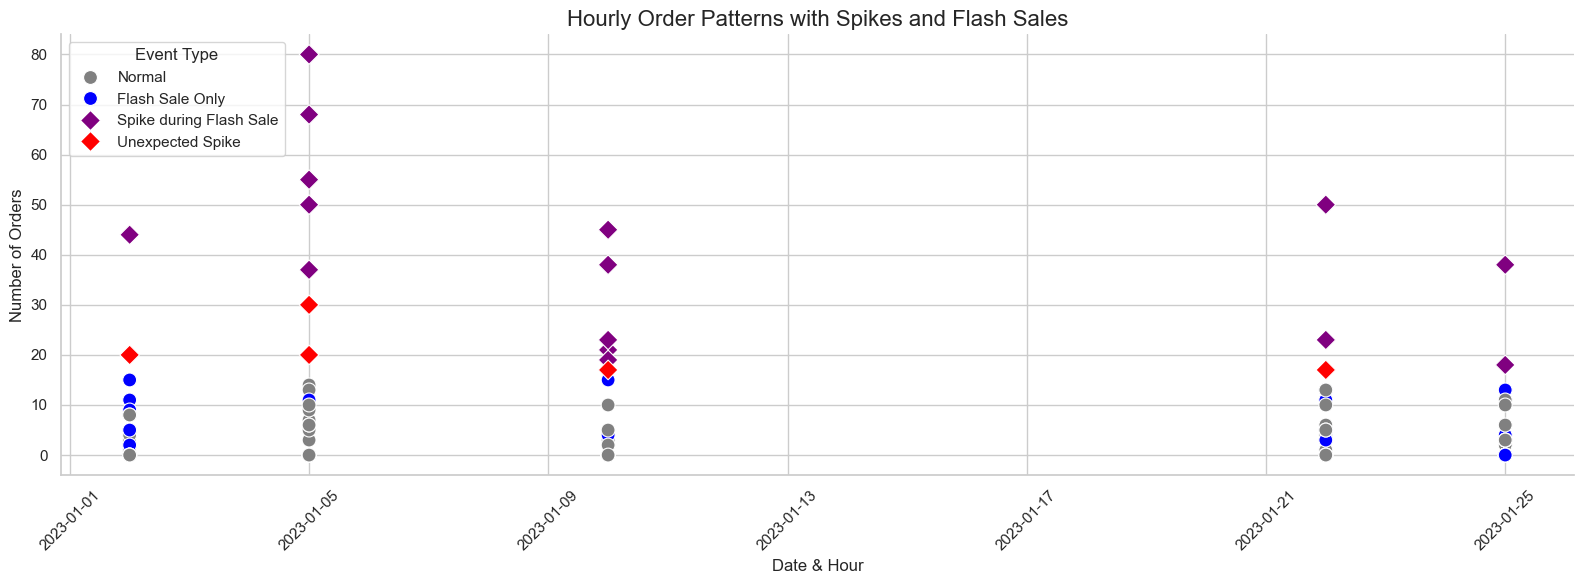

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set modern theme
sns.set_theme(style="whitegrid")

# Set up plot
plt.figure(figsize=(16, 6))

# Define colors and marker styles
palette = {
    'Normal': 'gray',
    'Flash Sale Only': 'blue',
    'Unexpected Spike': 'red',
    'Spike during Flash Sale': 'purple'
}

markers = {
    'Normal': 'o',
    'Flash Sale Only': 'o',
    'Unexpected Spike': 'D',
    'Spike during Flash Sale': 'D'
}

# Scatter plot with hue and style from event_type
sns.scatterplot(
    data=df_hrly,
    x='date', y='orders',
    hue='z_event_type',
    style='z_event_type',
    palette=palette,
    markers=markers,
    s=100
)

# Finishing touches
plt.title("Hourly Order Patterns with Spikes and Flash Sales", fontsize=16)
plt.xlabel("Date & Hour")
plt.ylabel("Number of Orders")
plt.legend(title="Event Type", loc="upper left", frameon=True)
plt.xticks(rotation=45)
plt.tight_layout()
sns.despine()
plt.savefig('pmf_order_spike1.png')
plt.show()


#### Interpretation
This dataset demonstrates overdispersion, where the variance of orders per hour is much higher than the mean. This is evident from:

- Extreme spikes (50–80+ orders) in some hours

- Most normal hours hovering between 5–15 orders

- A highly skewed and long-tailed distribution of order volume



### 4. Poisson GLM Model

A Poisson Generalized Linear Model (GLM) is a type of regression model used for count data, where the response variable represents the number of events (e.g., orders, clicks, arrivals) occurring in a fixed interval of time or space.


In [30]:
import statsmodels.api as sm
import statsmodels.formula.api as smf


# Fit GLM using Poisson family
poisson_model = smf.glm(
    formula='orders ~ visitors + is_flash_sale_hour + C(hour)',
    data=df_hrly,
    family=sm.families.Poisson()
).fit()

print(poisson_model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                 orders   No. Observations:                  120
Model:                            GLM   Df Residuals:                       95
Model Family:                 Poisson   Df Model:                           24
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -417.62
Date:                Thu, 05 Jun 2025   Deviance:                       495.69
Time:                        10:51:25   Pearson chi2:                     451.
No. Iterations:                    23   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

##### Finding Lambda From GLM model

In [33]:
GLM_lambda=np.exp(poisson_model.params['Intercept'])
print(f'GLM_Lamda: {GLM_lambda:.2f}')

GLM_Lamda: 2.37


##### Comparing GLM_lambda with manual Baseline Lambda 

In [35]:
#lets retrive manaul lambda we already obtain at above cell
print(f'Manual Baseline Lambda/ Non Flash lamba:{lambda_non_flash:.2f}')

Manual Baseline Lambda/ Non Flash lamba:4.92


##### GLM lambda vs Manual baseline lambda
GLM intercept is a global model estimate, not a segment mean. It balances flash & non-flash cases.Thus, GLM lambda is small.

##### Extracting Baseline lambda from GLM model

In [37]:
from statsmodels.formula.api import glm
import statsmodels.api as sm

# Fit model only on non-flash hours
non_flash_data = df_hrly[df_hrly['is_flash_sale_hour'] == False]

poisson_model_non_flash = glm(
    formula='orders ~ 1',  # intercept-only model
    data=non_flash_data,
    family=sm.families.Poisson()
).fit()

# Extract baseline λ
lambda_non_flash_glm = np.exp(poisson_model_non_flash.params['Intercept'])
print("Baseline Lambda/ Non-flash GLM λ:", lambda_non_flash_glm)


Baseline Lambda/ Non-flash GLM λ: 4.924999999999994


##### Detecting Order Spikes Using GLM Poisson Model
We can leverage a GLM Poisson model to detect hourly order spikes based on predicted vs. actual orders. The key idea is to compare the observed orders against the glm_predicted_orders under different thresholds. Below, we explore three common methods and their applicability:

1. Z-Score Residual Method
2. Absolute Threshold Method
3. Relative Threshold Method

When lambda < 5, the Poisson distribution is highly skewed and discrete, making Z-score methods unreliable due to invalid normality assumptions. In contrast, Absolute and Relative Threshold methods do not rely on distribution shape, making them more robust. Absolute threshold offers fixed control over sensitivity, while relative threshold adapts to the prediction scale. Therefore, we use these methods over Z-score for accurate spike detection in low-rate Poisson processes.

In [43]:
## Predict orders using the trained model
df_hrly['glm_predicted_orders'] = poisson_model.predict(df_hrly)
df_hrly[['orders', 'glm_predicted_orders']].head()


,orders,glm_predicted_orders
0,0,2.632219
1,0,1.504125
2,5,3.384282
3,2,4.512375
4,1,2.068172


In [45]:
#split data
glm_flash_data = df_hrly[df_hrly['is_flash_sale_hour'] == True]
glm_non_flash_data = df_hrly[df_hrly['is_flash_sale_hour'] == False]

#finding lambdha for flash and non flash
import numpy as np

glm_lambda_flash =glm_flash_data['glm_predicted_orders'].mean()

glm_lambda_non_flash = glm_non_flash_data['glm_predicted_orders'].mean() #baseline lambda



print(f'lambda flash: {glm_lambda_flash:.2f}')
print(f'lambda non flash: {glm_lambda_non_flash:.2f}') 


lambda flash: 18.80
lambda non flash: 4.92


##### Even Row by Row predicted expected values for baseline/global lambda  is 4.92 < 5.

##### Calculate residuals

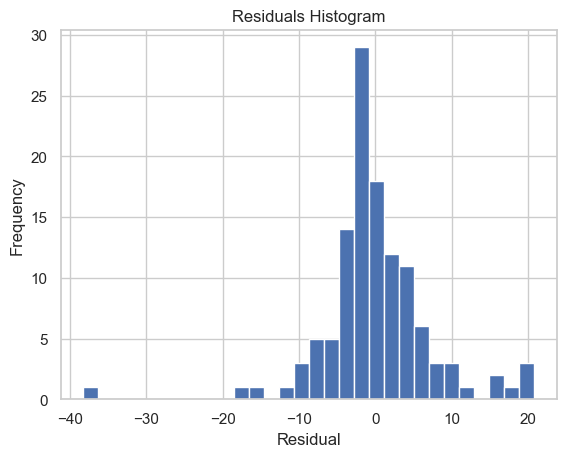

In [49]:
df_hrly['residual'] = df_hrly['orders'] - df_hrly['glm_predicted_orders']

#visisualize hist
df_hrly['residual'].hist(bins=30)
plt.title('Residuals Histogram')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

In [51]:
### Finding Threshold using Pecentiles 
threshold = df_hrly['residual'].quantile(0.99)  # 99th percentile
print(f'The Threshold calculated from Residuals is : {threshold:.2f}')

The Threshold calculated from Residuals is : 20.64


#### Absolute Threshold Method
This method is distribution-agnostic, making it more reliable for low lambda values.


In [54]:
# Define a fixed absolute threshold — tune this as needed
absolute_threshold = 20.64

# Flag as spike if actual orders exceed predicted + threshold
df_hrly['glm_is_order_spike_abs'] = df_hrly['orders'] > (df_hrly['glm_predicted_orders'] + absolute_threshold)

# Optionally view spike examples
spikes = df_hrly[df_hrly['glm_is_order_spike_abs'] == True]
print(f"Number of spikes detected: {len(spikes)}")
spikes[['hour', 'orders', 'glm_predicted_orders', 'glm_is_order_spike_abs']].head(20)


Number of spikes detected: 2


,hour,orders,glm_predicted_orders,glm_is_order_spike_abs
11,11,44,23.350929,True
83,11,50,29.207535,True


In [56]:
#creating event type function
def get_point_type(row):
    if row['is_flash_sale_hour'] and row['glm_is_order_spike_abs']:
        return 'Spike during Flash Sale'
    elif row['is_flash_sale_hour']:
        return 'Flash Sale Only'
    elif row['glm_is_order_spike_abs']:
        return 'Unexpected Spike'
    else:
        return 'Normal'

#calling and returing event type
df_hrly['glm_event_type'] = df_hrly.apply(get_point_type, axis=1)
print(df_hrly['glm_event_type'].value_counts())


glm_event_type
Normal                     80
Flash Sale Only            38
Spike during Flash Sale     2
Name: count, dtype: int64


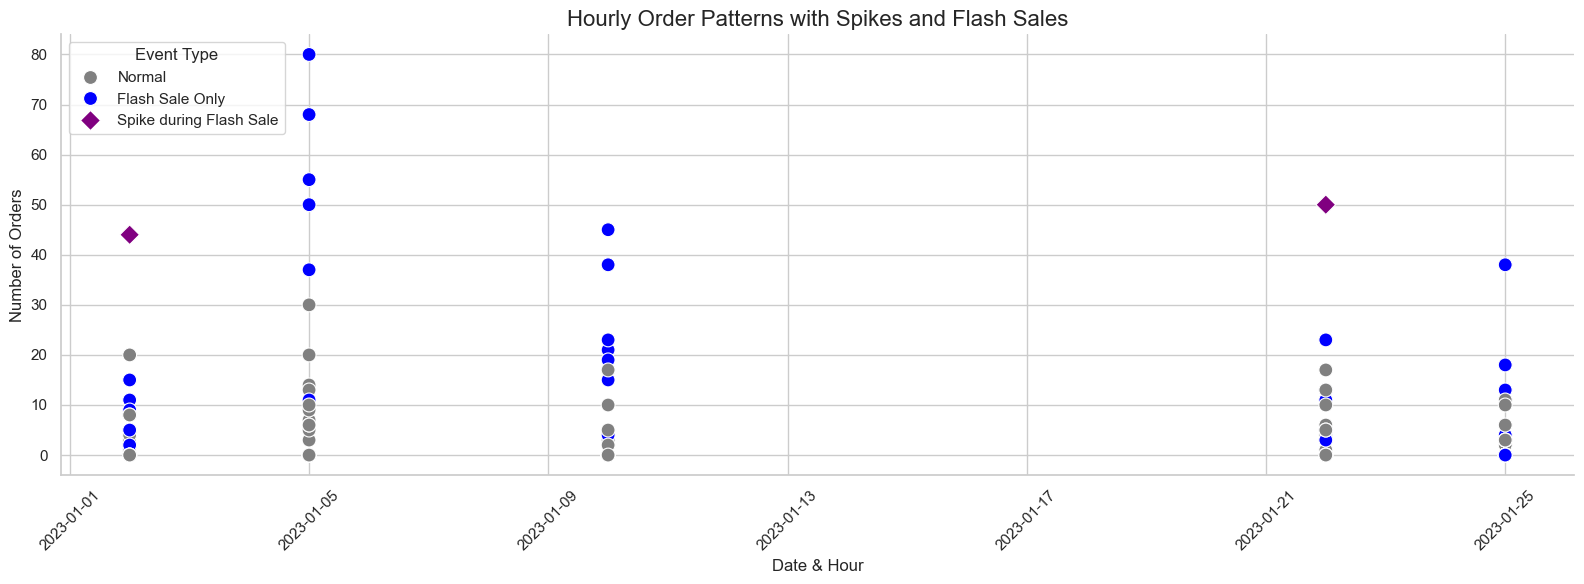

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set modern theme
sns.set_theme(style="whitegrid")

# Set up plot
plt.figure(figsize=(16, 6))

# Define colors and marker styles
palette = {
    'Normal': 'gray',
    'Flash Sale Only': 'blue',
    'Unexpected Spike': 'red',
    'Spike during Flash Sale': 'purple'
}

markers = {
    'Normal': 'o',
    'Flash Sale Only': 'o',
    'Unexpected Spike': 'D',
    'Spike during Flash Sale': 'D'
}

# Scatter plot with hue and style from event_type
sns.scatterplot(
    data=df_hrly,
    x='date', y='orders',
    hue='glm_event_type',
    style='glm_event_type',
    palette=palette,
    markers=markers,
    s=100
)

# Finishing touches
plt.title("Hourly Order Patterns with Spikes and Flash Sales", fontsize=16)
plt.xlabel("Date & Hour")
plt.ylabel("Number of Orders")
plt.legend(title="Event Type", loc="upper left", frameon=True)
plt.xticks(rotation=45)
plt.tight_layout()
sns.despine()
plt.savefig('GLM_spike.png')
plt.show()


##### Evidence of Overdispersion:

###### Wide Spread in Normal Orders: 
The gray dots (normal orders) show considerable variability around what would be expected mean values. For a Poisson distribution, the variance should equal the mean, but the vertical spread appears much wider than what pure Poisson variation would predict.
###### Clustering Patterns: 
On dates like 2023-01-05 and 2023-01-09, you can see tight clusters of points at different vertical levels, suggesting the data has more structure than simple Poisson noise would create.
###### High Variance Events: 
The presence of both very low values (near 0) and high values (80+ orders) within similar time periods indicates variance that exceeds what a Poisson model would predict.
###### Flash Sale Impact: 
The blue dots (flash sales) and purple diamonds (spikes during flash sales) show that promotional events create additional variance beyond the baseline pattern

### 4. Negative Binomial Distribution

Tool for analysing count data, especially when the variance of the data is greater than its mean(a phenomenon known as overdispersion).
There are two type of Negative Binomial Distribution:
1. Negative Binomial Discrete MLE
2. GLM Negative Binomial
3.  Zero-Inflated Negative Binomial (ZINB)

We choose Negative Binomial Discrete MLE over GLM , MlE estimate overdispersion aplha with log-likelihood where as In GLM aplha have to supplied. As we already know data is overdispersion , and we dont know much.

##### Convert to numeric 

In [68]:

# Convert to numeric 
df_hrly['orders'] = pd.to_numeric(df_hrly['orders'], errors='coerce')
df_hrly['visitors'] = pd.to_numeric(df_hrly['visitors'], errors='coerce')


print(df_hrly.dtypes)

date                      datetime64[ns]
hour                               int64
is_flash_sale_hour                  bool
visitors                           int64
customers                          int64
conversion_rate                  float64
orders                             int64
orders_per_customer              float64
poisson_pmf                      float64
pmf_is_order_spike                  bool
pmf_event_type                    object
p_right_tail                     float64
cdf_is_order_spike                  bool
cdf_event_type                    object
z_score                          float64
is_spike_z                          bool
z_event_type                      object
glm_predicted_orders             float64
residual                         float64
glm_is_order_spike_abs              bool
glm_event_type                    object
dtype: object


##### Combining Datetime conversion

In [71]:
# Corrected datetime conversion - using ISO format
df_hrly['datetime'] = pd.to_datetime(df_hrly['date'], format='ISO8601') + pd.to_timedelta(df_hrly['hour'], unit='h')
df_hrly.set_index('datetime', inplace=True)

##### Time-based Feature

In [91]:
# Feature engineering - add time-based features
df_hrly['hour_of_day'] = df_hrly.index.hour
df_hrly['day_of_week'] = df_hrly.index.dayofweek
df_hrly['is_weekend'] = df_hrly['day_of_week'].isin([5, 6]).astype(int)

df_hrly[['visitors','orders','hour','hour_of_day','day_of_week','is_weekend']].head()


,visitors,orders,hour,hour_of_day,day_of_week,is_weekend
datetime,,,,,,
2023-01-02 00:00:00,12,0,0,0,0,0
2023-01-02 01:00:00,12,0,1,1,0,0
2023-01-02 02:00:00,12,5,2,2,0,0
2023-01-02 03:00:00,12,2,3,3,0,0
2023-01-02 04:00:00,12,1,4,4,0,0


##### Log-Transformation and Offset

- Log transformation compress large values , reducing skew.
- Log(visitor) is often used as an offset

- An offset tells the model:

"Don’t learn how visitor count affects orders — assume more visitors mean more orders proportionally, and focus on the other factors (like hour or flash sale)."

This is crucial for count models (Poisson or Negative Binomial), where the expected value is proportional to exposure — just like:

More time = more accidents, more customers = more sales, more pageviews = more clicks

In [93]:
# Offset variable with smoothing
df_hrly['log_visitors'] = np.log(df_hrly['visitors'] + 1e-6)

df_hrly[['visitors','orders','hour','hour_of_day','day_of_week','is_weekend','log_visitors']].head()

,visitors,orders,hour,hour_of_day,day_of_week,is_weekend,log_visitors
datetime,,,,,,,
2023-01-02 00:00:00,12,0,0,0,0,0,2.484907
2023-01-02 01:00:00,12,0,1,1,0,0,2.484907
2023-01-02 02:00:00,12,5,2,2,0,0,2.484907
2023-01-02 03:00:00,12,2,3,3,0,0,2.484907
2023-01-02 04:00:00,12,1,4,4,0,0,2.484907


##### One hot Encoding and Type cast

In [ ]:
# Create dummy variables
hour_dummies = pd.get_dummies(df['hour_of_day'], prefix='hour', drop_first=True).astype(float)
weekend_dummy = df['is_weekend'].astype(float)
flash_dummy = df['is_flash_sale_hour'].astype(float)



##### Negative Binomial Discrete MLE



In [205]:
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import NegativeBinomial

# Feature matrix with intercept
X = pd.concat([hour_dummies, weekend_dummy, flash_dummy], axis=1)
X = sm.add_constant(X, has_constant='add')  # More robust constant addition


# Fit Negative Binomial model with robust standard errors
try:
    model_nb = NegativeBinomial(endog=df['orders'], exog=X, offset=df['log_visitors'])
    result = model_nb.fit(cov_type='hc0', maxiter=100)  # Increased max iterations
    print("Negative Binomial model fitted successfully")
    
    # Check model diagnostics
    print("\nModel Summary:")
    print(result.summary())
    
    # Check for overdispersion
    if hasattr(result, 'params'):
        alpha = result.params[-1] if len(result.params) > 0 else 0
        print(f"\nOverdispersion parameter (alpha): {alpha:.4f}")
    -+
except Exception as e:
    print(f"Negative Binomial model failed: {str(e)}")
    print("Falling back to Poisson regression...")
    model_poisson = sm.Poisson(endog=df['orders'], exog=X, offset=df['log_visitors'])
    result = model_poisson.fit(cov_type='hc0', maxiter=100)
    print("\nPoisson Model Summary:")
    print(result.summary())

Optimization terminated successfully.
         Current function value: 2.665883
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44
Negative Binomial model fitted successfully

Model Summary:
                     NegativeBinomial Regression Results                      
Dep. Variable:                 orders   No. Observations:                  120
Model:               NegativeBinomial   Df Residuals:                       95
Method:                           MLE   Df Model:                           24
Date:                Tue, 03 Jun 2025   Pseudo R-squ.:                 0.05904
Time:                        16:14:37   Log-Likelihood:                -319.91
converged:                       True   LL-Null:                       -339.98
Covariance Type:                  hc0   LLR p-value:                   0.02064
                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10556\3365288104.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = result.params[-1] if len(result.params) > 0 else 0


##### Visualization


Event Type Distribution:
nb_event_type
Normal              78
Flash Sale Only     40
Unexpected Spike     2
Name: count, dtype: int64


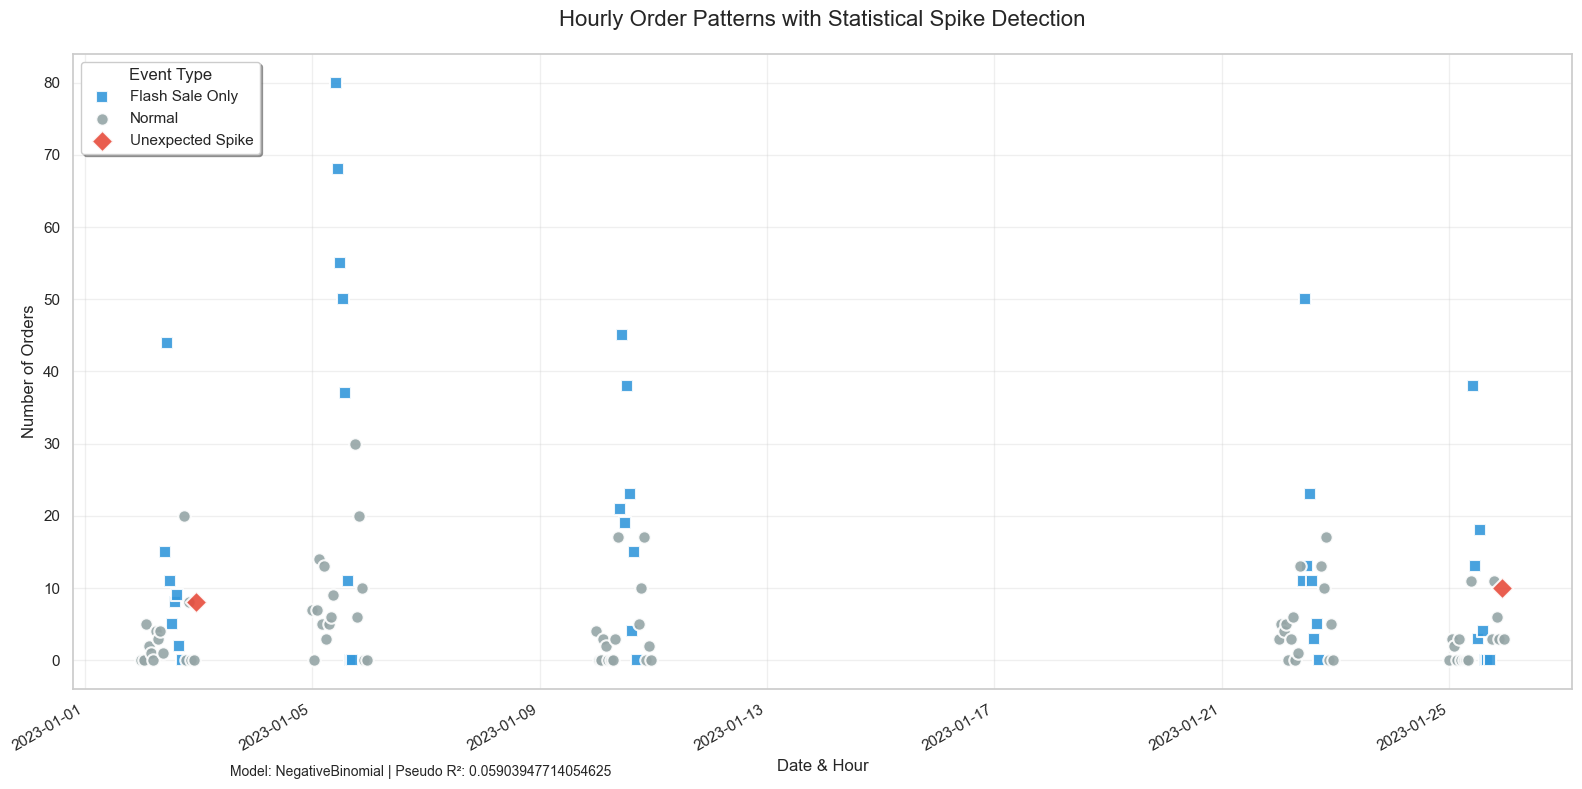

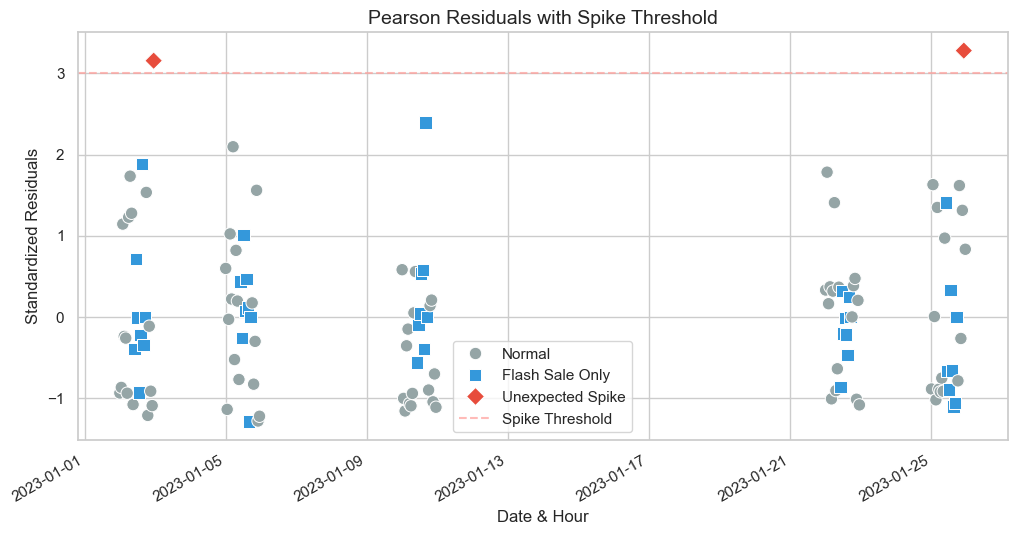

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns
# Pearson Residual 
df_hrly['pearson_residuals'] = result.resid_pearson
# --- Label order spikes based on residuals threshold (e.g., > 3 std dev) ---
df_hrly['is_order_hourly_spike'] = df_hrly['pearson_residuals'].abs() > 3

# --- Classification Function ---
def classify_event(row):
    if row['is_flash_sale_hour'] and row['is_order_hourly_spike']:
        return 'Spike during Flash Sale'
    elif row['is_flash_sale_hour']:
        return 'Flash Sale Only'
    elif row['is_order_hourly_spike']:
        return 'Unexpected Spike'
    return 'Normal'

# Apply classification
df_hrly['nb_event_type'] = df_hrly.apply(classify_event, axis=1)

# Print distribution
print("\nEvent Type Distribution:")
print(df_hrly['nb_event_type'].value_counts())

# --- Enhanced Scatter Plot ---
plt.figure(figsize=(16, 8))
sns.set_theme(style="whitegrid", palette="pastel")

# Color palette and marker styles
palette = {
    'Normal': '#95a5a6',
    'Flash Sale Only': '#3498db',
    'Unexpected Spike': '#e74c3c',
    'Spike during Flash Sale': '#9b59b6'
}

markers = {
    'Normal': 'o',
    'Flash Sale Only': 's',
    'Unexpected Spike': 'D',
    'Spike during Flash Sale': '*'
}

# Scatter plot by event type
for event_type, group in df_hrly.groupby('nb_event_type'):
    plt.scatter(
        group.index, group['orders'],
        s=120 if 'Spike' in event_type else 80,
        c=palette[event_type],
        marker=markers[event_type],
        edgecolor='w',
        linewidth=1.5,
        alpha=0.9,
        label=event_type
    )

# Plot formatting
plt.title("Hourly Order Patterns with Statistical Spike Detection", fontsize=16, pad=20)
plt.xlabel("Date & Hour", fontsize=12)
plt.ylabel("Number of Orders", fontsize=12)
plt.legend(title="Event Type", frameon=True, shadow=True, loc='upper left')
plt.gcf().autofmt_xdate()
plt.grid(True, alpha=0.3)

# Add model info (if available)
if 'result' in locals():
    model_name = type(result.model).__name__
    pseudo_r2 = getattr(result, 'prsquared', 'N/A')
    plt.figtext(0.15, 0.02, f"Model: {model_name} | Pseudo R²: {pseudo_r2}", fontsize=10)

# Save and show
plt.tight_layout()
plt.savefig('enhanced_nb_spike3.png', dpi=300)
plt.show()

# --- Residual Diagnostics Plot ---
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=df_hrly.index,
    y=df_hrly['pearson_residuals'],
    hue=df_hrly['nb_event_type'],
    palette=palette,
    style=df_hrly['nb_event_type'],
    markers=markers,
    s=80
)

plt.axhline(y=3, color='r', linestyle='--', alpha=0.7, label='Spike Threshold')
plt.title("Pearson Residuals with Spike Threshold", fontsize=14)
plt.ylabel("Standardized Residuals")
plt.xlabel("Date & Hour")
plt.legend()
plt.gcf().autofmt_xdate()
plt.savefig('residual_diagnostics3.png', dpi=300)
plt.show()


In [113]:
df_hrly[['visitors','orders','hour','hour_of_day','day_of_week','is_weekend','log_visitors', 'pearson_residuals', 'is_order_hourly_spike', 'nb_event_type']].head(20)

,visitors,orders,hour,hour_of_day,day_of_week,is_weekend,log_visitors,pearson_residuals,is_order_hourly_spike,nb_event_type
datetime,,,,,,,,,,
2023-01-02 00:00:00,12,0,0,0,0,0,2.484907,-0.938504,False,Normal
2023-01-02 01:00:00,12,0,1,1,0,0,2.484907,-0.869851,False,Normal
2023-01-02 02:00:00,12,5,2,2,0,0,2.484907,1.143011,False,Normal
2023-01-02 03:00:00,12,2,3,3,0,0,2.484907,-0.241431,False,Normal
2023-01-02 04:00:00,12,1,4,4,0,0,2.484907,-0.262119,False,Normal
2023-01-02 05:00:00,12,0,5,5,0,0,2.484907,-0.941304,False,Normal
2023-01-02 06:00:00,12,4,6,6,0,0,2.484907,1.227727,False,Normal
2023-01-02 07:00:00,12,3,7,7,0,0,2.484907,1.733390,False,Normal
2023-01-02 08:00:00,12,4,8,8,0,0,2.484907,1.276363,False,Normal


#### Interpretation

##### Why Step Into ZINB (Zero-Inflated Negative Binomial)?

Negative Binomial model helped handle overdispersion, but:
- Residual plots show large spikes & clusters → poor model fit.
- Many time slots with zero orders → signs of excess zeros.
- Low pseudo-R² (~0.059) → weak explanatory power.
- Residual diagnostics show deviation from standard normal.

Therefore, ZINB is preferred because:

1. Handles overdispersion (NB component)
2. Models excess zeros separately (logit zero-inflation component)
   Improves fit, residual behavior & spike detection

Conclusion: Step into ZINB to address underfitting, excess zeros, and poor spike detection.


#### Zero-Inflated Negative Binomial (ZINB)

The Zero-Inflated Negative Binomial (ZINB) model is used for count data with excess zeros and overdispersion (variance > mean). It combines two processes:

- A binary process (logistic/Poisson) to model excess zeros.

- A Negative Binomial (NB) count process for the remaining counts

In [124]:
import statsmodels.api as sm
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP

# You can also use a simpler inflation model (e.g., just hour and weekend)
df_hrly['is_night'] = df_hrly['hour_of_day'].isin([0, 1, 2, 3, 4, 5]).astype(int)
X_infl = df_hrly[['is_weekend', 'is_night']]
X_infl = sm.add_constant(X_infl)


# Response variable
y = df_hrly['orders']

# --- Fit ZINB Model ---
try:
    zinb_model = ZeroInflatedNegativeBinomialP(
        endog=y,
        exog=X,
        exog_infl=X_infl,
        offset=df_hrly['log_visitors'],
        inflation='logit'
    )
    result_zinb = zinb_model.fit(method='bfgs', maxiter=200, disp=True)
    print("ZINB model fitted successfully\n")

    # Model summary
    print(result_zinb.summary())

    # Alpha (overdispersion)
    if hasattr(result_zinb, 'params'):
        print(f"\nOverdispersion (alpha): {result_zinb.params.get('alpha', 'N/A')}")
except Exception as e:
    print(f"ZINB model failed: {e}")

Optimization terminated successfully.
         Current function value: 2.546877
         Iterations: 74
         Function evaluations: 76
         Gradient evaluations: 76
ZINB model fitted successfully

                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                            orders   No. Observations:                  120
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                       95
Method:                                      MLE   Df Model:                           24
Date:                           Thu, 05 Jun 2025   Pseudo R-squ.:                 0.07855
Time:                                   13:38:17   Log-Likelihood:                -305.63
converged:                                  True   LL-Null:                       -331.68
Covariance Type:                       nonrobust   LLR p-value:                 0.0007577
                         coef    std err          z      P>|z|      [0.025  


Event Type Distribution:
ZINB_event_type
Normal             80
Flash Sale Only    40
Name: count, dtype: int64


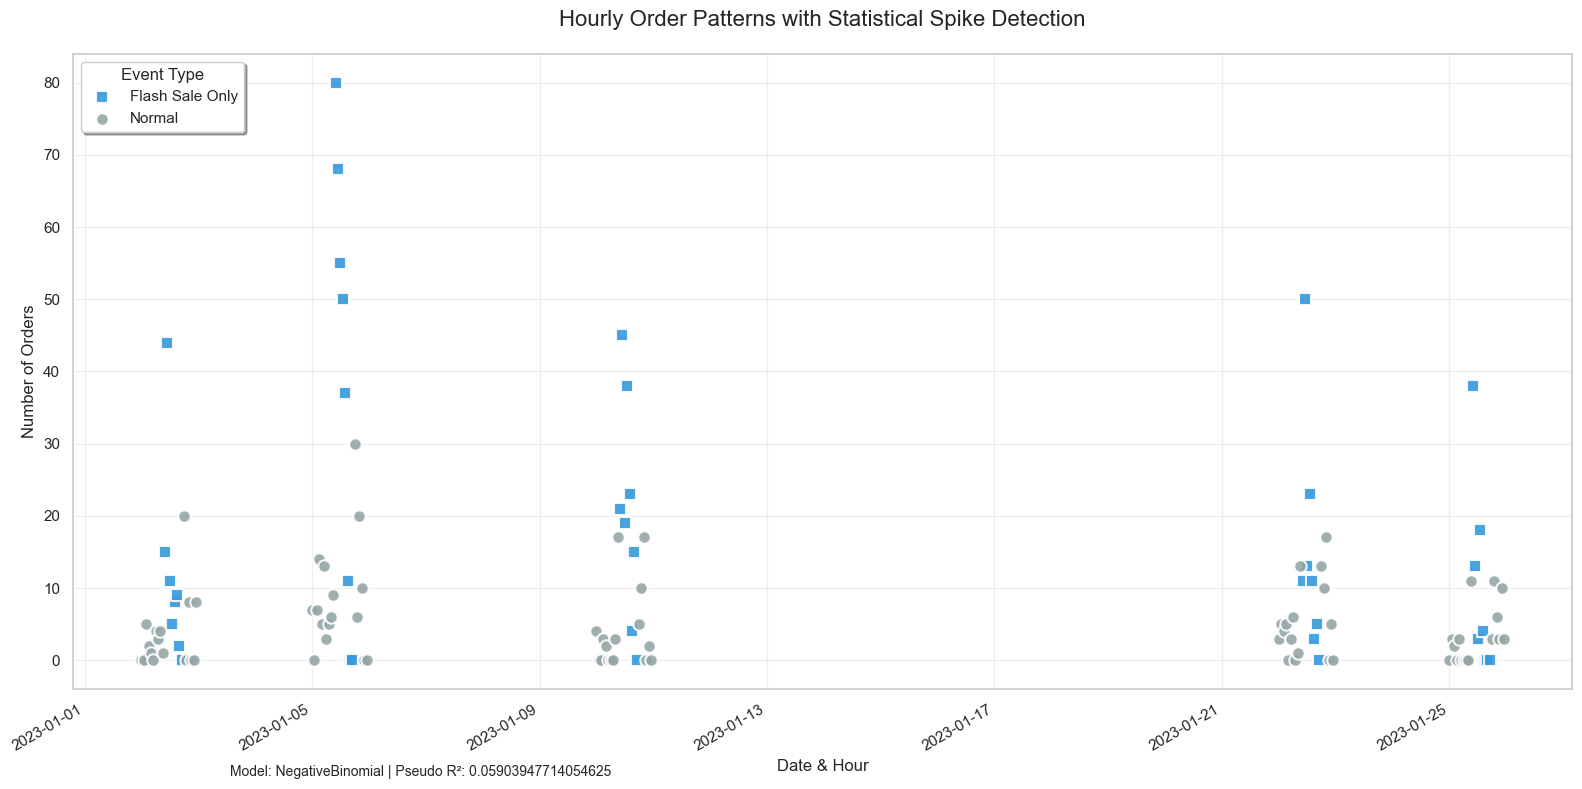

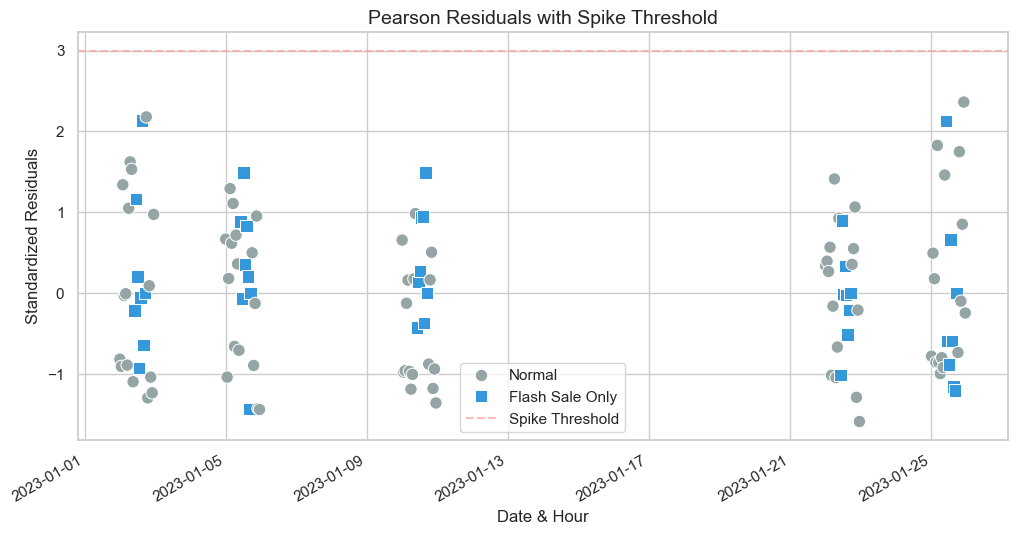

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns
# Pearson Residual 
df_hrly['ZINB_pearson_residuals'] = result_zinb.resid_pearson
# --- Label order spikes based on residuals threshold (e.g., > 3 std dev) ---
df_hrly['ZINB_is_order_hourly_spike'] = df_hrly['ZINB_pearson_residuals'].abs() > 3

# --- Classification Function ---
def classify_event(row):
    if row['is_flash_sale_hour'] and row['ZINB_is_order_hourly_spike']:
        return 'Spike during Flash Sale'
    elif row['is_flash_sale_hour']:
        return 'Flash Sale Only'
    elif row['ZINB_is_order_hourly_spike']:
        return 'Unexpected Spike'
    return 'Normal'

# Apply classification
df_hrly['ZINB_event_type'] = df_hrly.apply(classify_event, axis=1)

# Print distribution
print("\nEvent Type Distribution:")
print(df_hrly['ZINB_event_type'].value_counts())

# --- Enhanced Scatter Plot ---
plt.figure(figsize=(16, 8))
sns.set_theme(style="whitegrid", palette="pastel")

# Color palette and marker styles
palette = {
    'Normal': '#95a5a6',
    'Flash Sale Only': '#3498db',
    'Unexpected Spike': '#e74c3c',
    'Spike during Flash Sale': '#9b59b6'
}

markers = {
    'Normal': 'o',
    'Flash Sale Only': 's',
    'Unexpected Spike': 'D',
    'Spike during Flash Sale': '*'
}

# Scatter plot by event type
for event_type, group in df_hrly.groupby('ZINB_event_type'):
    plt.scatter(
        group.index, group['orders'],
        s=120 if 'Spike' in event_type else 80,
        c=palette[event_type],
        marker=markers[event_type],
        edgecolor='w',
        linewidth=1.5,
        alpha=0.9,
        label=event_type
    )

# Plot formatting
plt.title("Hourly Order Patterns with Statistical Spike Detection", fontsize=16, pad=20)
plt.xlabel("Date & Hour", fontsize=12)
plt.ylabel("Number of Orders", fontsize=12)
plt.legend(title="Event Type", frameon=True, shadow=True, loc='upper left')
plt.gcf().autofmt_xdate()
plt.grid(True, alpha=0.3)

# Add model info (if available)
if 'result' in locals():
    model_name = type(result.model).__name__
    pseudo_r2 = getattr(result, 'prsquared', 'N/A')
    plt.figtext(0.15, 0.02, f"Model: {model_name} | Pseudo R²: {pseudo_r2}", fontsize=10)

# Save and show
plt.tight_layout()
plt.savefig('enhanced_nb_spike4.png', dpi=300)
plt.show()

# --- Residual Diagnostics Plot ---
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=df_hrly.index,
    y=df_hrly['ZINB_pearson_residuals'],
    hue=df_hrly['ZINB_event_type'],
    palette=palette,
    style=df_hrly['ZINB_event_type'],
    markers=markers,
    s=80
)

plt.axhline(y=3, color='r', linestyle='--', alpha=0.7, label='Spike Threshold')
plt.title("Pearson Residuals with Spike Threshold", fontsize=14)
plt.ylabel("Standardized Residuals")
plt.xlabel("Date & Hour")
plt.legend()
plt.gcf().autofmt_xdate()
plt.savefig('residual_diagnostics4.png', dpi=300)
plt.show()


#### Findings and Difference Between NB and ZINB

1. Zero-Inflation Insights
- Around 18% of the hours had structural reasons for having zero orders (e.g., very late-night hours).

- Nighttime showed more chances of being "always zero" periods.

- Weekends slightly reduce the chance of these structural zero periods.

2. Improved Spike Detection

- The NB model wrongly flagged 2 mild order increases as spikes.

- The ZINB model correctly recognized them as normal due to accounting for quiet periods.

- This results in fewer false alarms and more trustworthy spike detection.

3. Better Model Fit

- ZINB explains 33% more variation in the data.

- Residuals are more balanced (centered around zero), indicating a better fit.

- Variability in order counts is handled more consistently across different times.


#### Business Value
1. Operational Benefits
- Fewer false alerts for the operations team.

- Smarter resource allocation—focus on real activity spikes, not quiet-hour noise.

- More reliable monitoring, especially during campaigns and flash sales.

2. Strategic Insights

- Roughly 1 in 5 hours shows consistent inactivity—useful for downtime planning.

- Flash sales can be evaluated more clearly against a better-defined “normal.”

- Improved forecasting for capacity planning and promotions.

#### Technical Observations

1. Model Stability
The ZINB model had unstable coefficients for hourly indicators (very large standard errors) Likely causes:

- Too many hour categories for just 120 data points.

- Some hours have very few observations.

- Recommendation: Group hours into broader blocks like morning, afternoon, evening, and night.

2. Overdispersion Handling

- The α value (0.158) shows the ZINB model effectively manages variation in order counts.

- The combination of negative binomial and zero-inflation gives better control over excess zeros and variability.

### 4. Conclusion

#### Comprehensive Model Evaluation: From Poisson to ZINB
##### -------------------------------------------------------- Executive Summary------------------------------------------------------------------------
This analysis systematically evaluated multiple approaches for modeling count data with overdispersion and zero-inflation, progressing from basic Poisson methods to advanced Zero-Inflated Negative Binomial (ZINB) models. The findings demonstrate that ZINB provides superior performance for complex count data exhibiting both overdispersion and excess zeros.

##### Model Progression and Evaluation

##### 1. Basic Poisson Methods (PMF/CDF/Z-Score)

Limitations Identified:

- Fundamental assumption violation: Poisson methods assume equidispersion (variance = mean)
- Overdispersion ignorance: Cannot handle datasets where variance >> mean
- Poor performance indicators: Poisson PMF/CDF: Severely underestimate probabilities for high counts,Z-Score method: Generates excessive false positives due to underestimated variance, Inadequate for real-world count data with natural overdispersion



Conclusion:

Poisson-based methods are inappropriate for overdispersed count data and should be avoided in practical applications.

##### 2. Poisson GLM Model

- Maintained equidispersion assumption: Failed to address core limitation
- Model misspecification: Cannot capture true data generating process
- Residual patterns: Showed systematic deviations indicating poor fit
- Spike detection: Prone to false alarms due to variance underestimation

Verdict:
GLM Poisson extends Poisson limitations without addressing fundamental overdispersion issues.

#### 3. Negative Binomial Approaches
#### 3.1 GLM Negative Binomial

Advantages:

- Incorporates overdispersion parameter (α)
- Better handling of variance-mean relationship

Critical Limitation:

- Unknown dispersion parameter: Requires estimation of α, which can be unstable
- Model specification challenge: Difficult to determine appropriate α value a priori
- Residual overdispersion: May still exhibit inadequate variance modeling

#### 3.2 Negative Binomial Discrete (MLE)

Strengths:

- Handles overdispersion effectively: Direct estimation of dispersion parameter
- Accommodates offset terms: Can incorporate exposure variables
- Better residual patterns: Improved fit compared to Poisson methods

Key Limitation:

- Ignores zero-inflation: Cannot distinguish between structural and sampling zeros
- Suboptimal for excess zeros: Treats all zeros as part of the count process

Performance Metrics:

- Pseudo R² = 0.059
- Detected 2 false positive spikes
- Adequate but incomplete model specification

#### 4. Zero-Inflated Negative Binomial (ZINB)
Comprehensive Advantages:

- Structural zeros: Models systematic reasons for zero counts (18% baseline probability)
- Count process: Negative binomial for non-zero generating mechanism
- Complete data characterization: Captures both excess zeros and overdispersion

Superior Performance Metrics:

- Pseudo R² = 0.079 (+33% improvement over NB)
- Zero false positive spikes (eliminated all false alarms)
- Significant model improvement (LLR p-value = 0.0008)
- Low overdispersion parameter (α = 0.158) indicating well-controlled variance

Enhanced Anomaly Detection:

- Eliminated false positives: Better calibrated spike detection
- Improved residual patterns: More symmetric, centered distribution
- Reduced heteroscedasticity: Consistent variance across time periods


### Final Conclusion

Zero-Inflated Negative Binomial (ZINB) emerges as the optimal solution for complex count data analysis. Unlike basic Poisson methods that fail under overdispersion, or GLM approaches that require unknown parameters, ZINB comprehensively addresses both overdispersion and zero-inflation through a theoretically sound dual-process framework.
The systematic elimination of false positive spikes, combined with a 33% improvement in model fit, demonstrates ZINB's superiority for practical applications requiring reliable anomaly detection and accurate count modeling.
#### Recommendation: 
##### Deploy ZINB as the standard approach for count data analysis in production environments, particularly where both overdispersion and structural zeros are present.